In [2]:
# Cell 1: Setup for Geographic Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Try importing folium for interactive maps
try:
    import folium
    from folium.plugins import HeatMap, MarkerCluster
    FOLIUM_AVAILABLE = True
    print("✅ Folium library detected. Interactive maps enabled.")
except ImportError:
    FOLIUM_AVAILABLE = False
    print("⚠️ Folium not found. Only static maps will be generated.")
    print("Tip: Run '!pip install folium' to enable interactive maps.")

# --- Configuration ---
INPUT_FILE = '../../data/processed/listings_cleaned_with_target.csv'
FIGURES_PATH = '../../outputs/figures/'
MAPS_PATH = '../../outputs/maps/'

os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(MAPS_PATH, exist_ok=True)

# Set style
sns.set_style("white") 
plt.rcParams['figure.figsize'] = (12, 10)

# Load Data
if os.path.exists(INPUT_FILE):
    df_geo = pd.read_csv(INPUT_FILE)
    print(f"Data Loaded")
    
else:
    print(f"Error: {INPUT_FILE} not found.")

⚠️ Folium not found. Only static maps will be generated.
Tip: Run '!pip install folium' to enable interactive maps.
Data Loaded


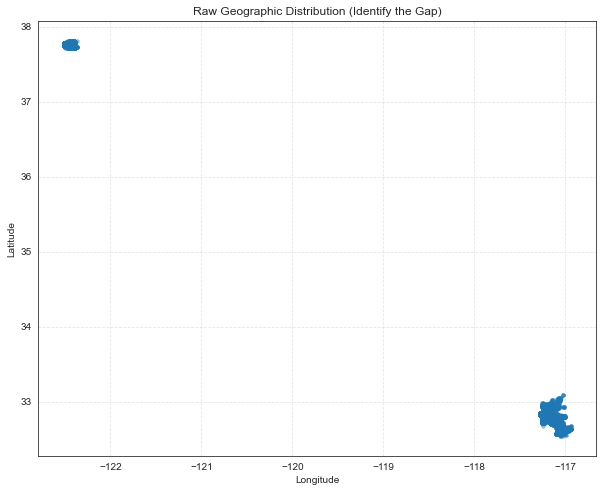

ACTION: Look at the Y-axis (Latitude). Find a value between the two city clusters.


In [3]:
# Cell 2: Initial Scatter Plot to Identify the Split Threshold
if 'df_geo' in locals():
    plt.figure(figsize=(10, 8))
    
    # Plot all points
    sns.scatterplot(
        data=df_geo, 
        x='longitude', 
        y='latitude', 
        alpha=0.5, 
        edgecolor=None,
        s=15
    )
    
    plt.title("Raw Geographic Distribution (Identify the Gap)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Save the figure
    plt.savefig(f"{FIGURES_PATH}01_raw_distribution.png", dpi=300)
    plt.show()
    
    print("ACTION: Look at the Y-axis (Latitude). Find a value between the two city clusters.")

In [4]:
# Cell 3: Splitting Data into San Francisco and San Diego

# --- CONFIGURATION ---
SPLIT_LONGITUDE_THRESHOLD = -120.0 
# ---------------------

print(f"Splitting data based on Longitude Threshold: {SPLIT_LONGITUDE_THRESHOLD}")

# 1. San Francisco (West of -120)
# SF is typically around -122 longitude
df_sf = df_geo[df_geo['longitude'] < SPLIT_LONGITUDE_THRESHOLD].copy()
df_sf['city_label'] = 'San Francisco'

# 2. San Diego (East of -120)
# SD is typically around -117 longitude
df_sd = df_geo[df_geo['longitude'] >= SPLIT_LONGITUDE_THRESHOLD].copy()
df_sd['city_label'] = 'San Diego'

# 3. Print Summary
print(f"\n--- Split Results ---")
print(f"San Francisco (West) Count : {len(df_sf)} records")
print(f"San Diego (East) Count     : {len(df_sd)} records")
print(f"Total Check                : {len(df_sf) + len(df_sd)}")

Splitting data based on Longitude Threshold: -120.0

--- Split Results ---
San Francisco (West) Count : 7497 records
San Diego (East) Count     : 12415 records
Total Check                : 19912


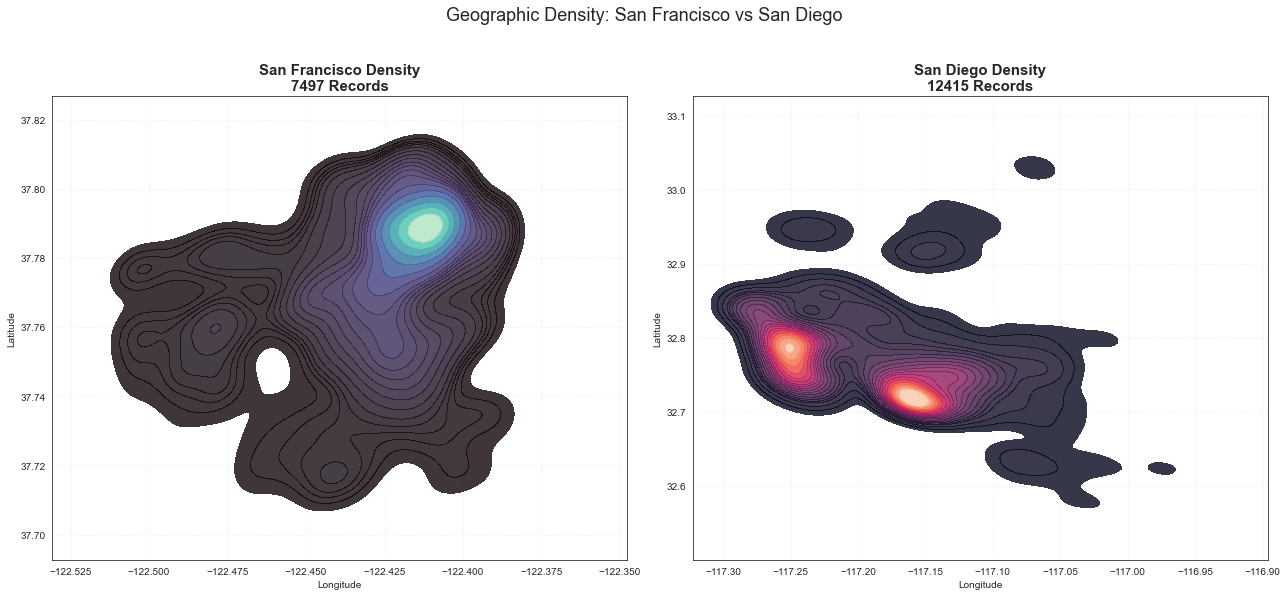

In [5]:
# Cell 4: Visual Density Heatmaps for San Francisco & San Diego

# Set up the figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# --- Plot 1: San Francisco Heatmap ---
if not df_sf.empty:
    sns.kdeplot(
        data=df_sf,
        x='longitude',
        y='latitude',
        fill=True,
        cmap='mako',       # Using a Blue theme for SF (Bay Area)
        levels=20,          # Increased detail
        thresh=0.05,
        alpha=0.8,
        ax=axes[0]
    )
    axes[0].set_title(f"San Francisco Density\n{len(df_sf)} Records", fontsize=15, fontweight='bold')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid(True, linestyle=':', alpha=0.4)
else:
    axes[0].text(0.5, 0.5, "No Data for San Francisco", ha='center', va='center')

# --- Plot 2: San Diego Heatmap ---
if not df_sd.empty:
    sns.kdeplot(
        data=df_sd,
        x='longitude',
        y='latitude',
        fill=True,
        cmap='rocket',        # Using a Red theme for San Diego (Warmer)
        levels=20,
        thresh=0.05,
        alpha=0.8,
        ax=axes[1]
    )
    axes[1].set_title(f"San Diego Density\n{len(df_sd)} Records", fontsize=15, fontweight='bold')
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")
    axes[1].grid(True, linestyle=':', alpha=0.4)
else:
    axes[1].text(0.5, 0.5, "No Data for San Diego", ha='center', va='center')

# Final Adjustments
plt.suptitle(f"Geographic Density: San Francisco vs San Diego", fontsize=18, y=1.03)
plt.tight_layout()

# Save the combined figure with new naming
plt.savefig(f"{FIGURES_PATH}03_sf_vs_sd_density.png", dpi=300, bbox_inches='tight')

# Display plot
plt.show()

--- Processing San Francisco Neighborhoods ---


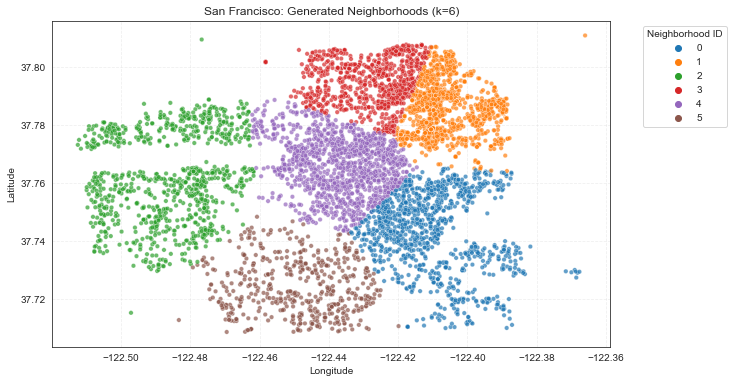


--- Processing San Diego Neighborhoods ---


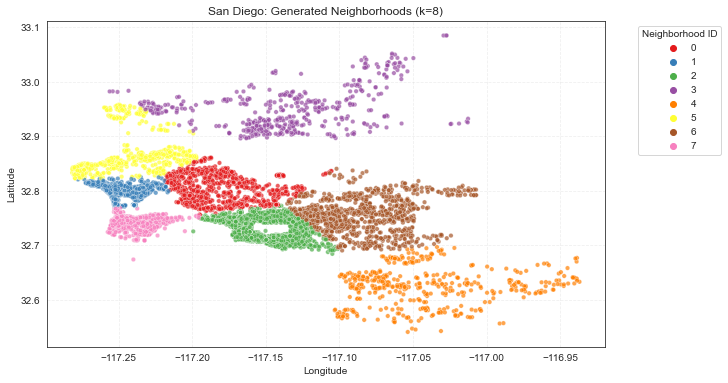

✅ Clustering complete. 'neighborhood_id' added to df_sf and df_sd.


In [6]:
# Cell 5: Spatial Clustering using K-Means (Linear Approach)
from sklearn.cluster import KMeans

# --- PART 1: SAN FRANCISCO CLUSTERING (k=6) ---
print("--- Processing San Francisco Neighborhoods ---")

# 1. Fit K-Means for SF
# We use 6 clusters for SF as it is dense and compact
kmeans_sf = KMeans(n_clusters=6, random_state=42, n_init=10)
sf_coordinates = df_sf[['latitude', 'longitude']]

# 2. Assign Clusters directly to the dataframe
df_sf['neighborhood_id'] = kmeans_sf.fit_predict(sf_coordinates)

# 3. Visualize SF Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sf, x='longitude', y='latitude', 
    hue='neighborhood_id', palette='tab10', 
    s=20, alpha=0.7
)
plt.title('San Francisco: Generated Neighborhoods (k=6)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Neighborhood ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


# --- PART 2: SAN DIEGO CLUSTERING (k=8) ---
print("\n--- Processing San Diego Neighborhoods ---")

# 1. Fit K-Means for SD
# We use 8 clusters for SD as it covers a larger area
kmeans_sd = KMeans(n_clusters=8, random_state=42, n_init=10)
sd_coordinates = df_sd[['latitude', 'longitude']]

# 2. Assign Clusters directly to the dataframe
df_sd['neighborhood_id'] = kmeans_sd.fit_predict(sd_coordinates)

# 3. Visualize SD Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sd, x='longitude', y='latitude', 
    hue='neighborhood_id', palette='Set1', 
    s=20, alpha=0.7
)
plt.title('San Diego: Generated Neighborhoods (k=8)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Neighborhood ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print("✅ Clustering complete. 'neighborhood_id' added to df_sf and df_sd.")

--- San Francisco Price Stats ---


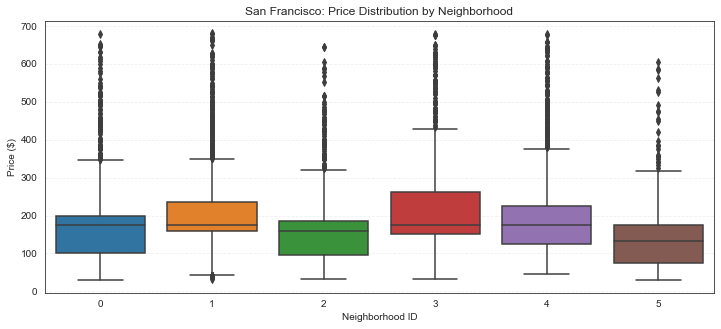

                 count    mean  median
neighborhood_id                       
0                 1081  181.15   175.0
1                 2163  203.51   175.0
2                  935  166.46   158.0
3                 1383  214.86   175.0
4                 1422  202.34   175.0
5                  513  143.48   132.0

--- San Diego Price Stats ---


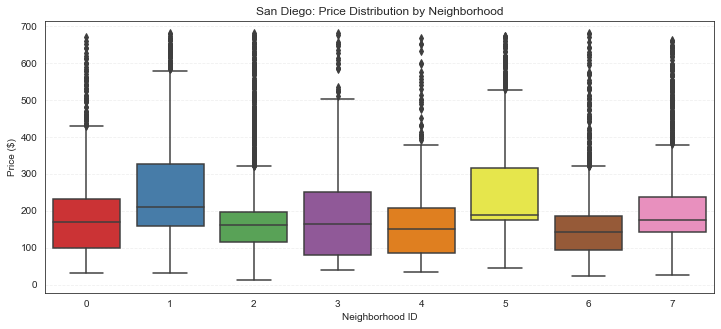

                 count    mean  median
neighborhood_id                       
0                 1102  187.06   168.5
1                 2436  253.63   209.0
2                 3900  177.40   160.0
3                  557  187.17   164.0
4                  472  172.92   150.0
5                 1076  249.89   188.0
6                 1361  163.94   143.0
7                 1511  209.95   175.0


In [7]:
# Cell 6: Price Distribution Analysis by Neighborhood

# --- PART 1: SAN FRANCISCO PRICE ANALYSIS ---
print("--- San Francisco Price Stats ---")

# 1. Boxplot for Prices
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_sf, x='neighborhood_id', y='price', palette='tab10')
plt.title('San Francisco: Price Distribution by Neighborhood')
plt.ylabel('Price ($)')
plt.xlabel('Neighborhood ID')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# 2. Print numeric stats (Mean & Median)
sf_stats = df_sf.groupby('neighborhood_id')['price'].agg(['count', 'mean', 'median'])
print(sf_stats.round(2))


# --- PART 2: SAN DIEGO PRICE ANALYSIS ---
print("\n--- San Diego Price Stats ---")

# 1. Boxplot for Prices
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_sd, x='neighborhood_id', y='price', palette='Set1')
plt.title('San Diego: Price Distribution by Neighborhood')
plt.ylabel('Price ($)')
plt.xlabel('Neighborhood ID')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

# 2. Print numeric stats (Mean & Median)
sd_stats = df_sd.groupby('neighborhood_id')['price'].agg(['count', 'mean', 'median'])
print(sd_stats.round(2))

In [8]:
# Cell 7: Save Processed Geographic Data

import os
import pandas as pd

# 1. Combine the dataframes back together
# We want a single dataset with the new 'city_label' and 'neighborhood_id' columns
if 'df_sf' in locals() and 'df_sd' in locals():
    # Concatenate the two city dataframes
    df_final_geo = pd.concat([df_sf, df_sd], ignore_index=True)
    
    print(f"--- Saving Data ---")
    print(f"Total Records: {len(df_final_geo)}")
    
    # Check if key columns exist before saving
    expected_cols = ['city_label', 'neighborhood_id']
    existing_cols = [col for col in expected_cols if col in df_final_geo.columns]
    print(f"New Features Included: {existing_cols}")
    
    # 2. Define Output Path
    # Ensure the directory exists
    OUTPUT_DIR = '../../data/processed/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    OUTPUT_FILE = f"{OUTPUT_DIR}listings_with_geo_features.csv"
    
    # 3. Save to CSV
    df_final_geo.to_csv(OUTPUT_FILE, index=False)
    print(f"\n✅ Success! Data saved to: {OUTPUT_FILE}")
    print("Ready for the next stage (Task 1.17 - Class Distribution Analysis).")
    
else:
    print("❌ Error: Dataframes 'df_sf' or 'df_sd' not found. Cannot save.")

--- Saving Data ---
Total Records: 19912
New Features Included: ['city_label', 'neighborhood_id']

✅ Success! Data saved to: ../../data/processed/listings_with_geo_features.csv
Ready for the next stage (Task 1.17 - Class Distribution Analysis).
